In [39]:
# ALLEGHENY DATASET ANALYSIS, GROUP 69
    # Andy Thai           - A12112599
    # Johnson Pang        - A12318209
    # Ronald Baldonado    - A11948171
    # Haoyuan Wang        - A12102032

# Introduction and Background:

Preventing and understanding the underlying causes of car accidents continues to be a key public safety issue. Car accidents remain commonplace throughout the United States, retaining its status as a significant cause of death. Thus, it is important that this issue be studied as to further prevent deaths and property damage.
 
Analysts point to a myriad of reasons as to why car accidents occur. According to the Critical Reasons for Crashes Investigated in the National Motor Vehicle Crash Causation Survey (2015), for the 5470 weighted samples, about 50% of the critical reasons for car crashes involve slick roads (loose debris, ice, etc), while fog/rain/snow are involved in around 4% of crashes. Note, however, that these given reasons are not the “primary causes” of the car crashes, just the “immediate reason for the critical pre-crash event and is often the last failure in the causal chain of events leading up to the crash.”
 
In addition, according to the Road Weather Management Program’s “How Do Weather Events Impact Roads?”, precipitation and fog causes a lessens vehicle traction and environmental visibility. The website also states that 22% of crashes from 2005-2014 involve poor weather, including slick road conditions. Wet pavement, rain, and snow/sleet are involved in 73%, 46% and 17%, of weather related crashes, respectively.

<h3>Hypothesis:</h3>

Given this background information, we hope to find patterns of interest between weather, environmental conditions and poor driving, in regards to injury severity and and the amount of injuries within crashes in Allegheny. By analyzing these patterns, we hope to provide more insight into car accidents and contribute to preventing more unnecessary destruction.

In [40]:
# General import statements
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# SciPy
import scipy.stats as stats
from scipy.stats import normaltest

# Statmodels & patsy
import patsy
import statsmodels.api as sm

# Gmaps API
import gmaps
api = ""
gmaps.configure(api_key=api)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Description
The dataset we will be using for our project will be taken directly from <https://catalog.data.gov/dataset/allegheny-county-crash-data>. 

Specifically, the “2016 Allegheny County Crash Data” is a sizeable dataset with 187 features for each observation including the latitude and longitude location of the crash, the street name, the weather conditions, and various other driving/driver conditions that may contribute to the car crash occurring. The total amount of observations within the 2016 data is about 12,900 observations throughout the year. 

In [41]:
# 2016 crash data
url_2016 = 'https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/9ccea350-e062-45e2-ade5-45e9378f40d2/download/reordered2016crashes.csv'

# 2004 - 2016 crash data
# Not used but here for potential reference
url_all = 'https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/2c13021f-74a9-4289-a1e5-fe0472c89881/download/all-crashes2004-2016.csv'

# Load dataframe
df_original = pd.read_csv(url_2016)

# Data Cleaning and Preprocessing
Before we do any work on the data, we must determine what categories that may be of relevant interest to our analysis. We refer to the data dictionary (provided at: <https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/4df9a3c6-34c1-45a5-936e-80758f9f38a5/download/allegheny-county-crash-data-dictionary.pdf>) to find out what each category's definition and the meanings of their corresponding values.


We separate potentially useful categories by relation for indexing below, and combine them all into a final trimmed dataset containing only the categories we deem of interest. Then, we drop the null data values.

We aim to use the MAX_SEVERITY_LEVEL category. However, the values are not sorted in ascending order; the values go by:

0 - Not injured

1 - Killed

2 - Major injury

3 - Moderate injury

4 - Minor injury

8 - Injury/ Unknown Severity

9 - Unknown


We rectify this issue by reordering the values so they match the following schema:

0 - Not injured

1 - Minor injury

2 - Moderate injury

3 - Major injury

4 - Killed

8 - Injury/ Unknown Severity

9 - Unknown

In [42]:
# Create related categories for indexing
category_time = ["CRASH_YEAR", "CRASH_MONTH", "TIME_OF_DAY", "HOUR_OF_DAY"]

category_conditions = ["ILLUMINATION", "WEATHER", "ROAD_CONDITION"]

category_type = ["COLLISION_TYPE", "URBAN_RURAL"]

category_people_count = ["PERSON_COUNT", "VEHICLE_COUNT"] 

category_injury = ["FATAL_COUNT", "INJURY_COUNT", "MAJ_INJ_COUNT", "MOD_INJ_COUNT", "MIN_INJ_COUNT", \
                   "UNK_INJ_DEG_COUNT", "MAX_SEVERITY_LEVEL", "FATAL_OR_MAJ_INJ"]

category_belt = ["UNBELTED", "UNBELTED_OCC_COUNT", "UNB_DEATH_COUNT", "UNB_MAJ_INJ_COUNT", "BELTED_DEATH_COUNT", \
                 "BELTED_MAJ_INJ_COUNT"]

category_age = ["DRIVER_COUNT_16YR", "DRIVER_COUNT_17YR", "DRIVER_COUNT_18YR", "DRIVER_COUNT_19YR", \
                "DRIVER_COUNT_20YR", "DRIVER_COUNT_50_64YR", "DRIVER_COUNT_65_74YR", "DRIVER_COUNT_75PLUS"]

category_location = ["LATITUDE", "LONGITUDE", "DEC_LAT", "DEC_LONG", "STREET_NAME"]

category_alcohol = ["ALCOHOL_RELATED", "DRINKING_DRIVER", "UNDERAGE_DRNK_DRV", "IMPAIRED_DRIVER"]

category_attention = ["CELL_PHONE", "DISTRACTED", "FATIGUE_ASLEEP"]

category_speed = ["LIMIT_65MPH", "SPEEDING", "SPEEDING_RELATED", "AGGRESSIVE_DRIVING"]

# Combine all categories
categories_all = category_time + category_conditions + category_type + category_people_count + \
                category_injury + category_belt + category_age + category_location + \
                category_alcohol + category_attention + category_speed

# Trim original dataframe into relevant data
df_trimmed = df_original[categories_all]

In [43]:
# Drop null values
df_trimmed.dropna()

# Reorder severity levels in ascending order; 5 is not used in the dictionary and functions as a temp value
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(1, 5)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(4, 1)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(5, 4)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(2, 5)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(3, 2)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(5, 3)

# Data Visualization

Below we will run code on our data and visualize the information into a more visually readable format.

<h3>Google Maps Heatmap</h3>

The code below outputs a Google Maps heatmap of the latitudes and longitudes of all of the crash locations within the dataset. 

This is accomplished via the gmaps API located at <https://github.com/pbugnion/gmaps>. 

In [44]:
# Get latitudes and longitudes of accident locations
df_location = df_trimmed[category_location]
df_location_dec = df_location[['DEC_LAT','DEC_LONG']]
loc_series = df_location_dec.as_matrix(['DEC_LAT','DEC_LONG'])

# Do not plot NaN values on gmaps
loc_list = []
for i in loc_series:
    if( not math.isnan(i[0]) and not math.isnan(i[1])):
        loc_list.append((i[0],i[1]))

# Create gmaps figure and show
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(loc_list)
fig.add_layer(heatmap_layer)
fig

Widget Javascript not detected.  It may not be installed or enabled properly.


The above code may not display a gmaps figure when viewed on GitHub. 

Attached below are screenshots of the gmaps figure.

ATTACH GMAPS FIGURES HERE

# DRUNK DRIVING

<h3>Drunk Driving with Maximum Injury Severity Levels</h3>

Below we attempt to find relations between drunk driving and injury severity levels within Allegheny accidents.

In [45]:
# Get drinking categories
df_isDrunk = df_trimmed[category_alcohol + category_injury]
df_isDrunk = df_isDrunk[["DRINKING_DRIVER","MAX_SEVERITY_LEVEL"]]

# Get rid of severity levels over 4 (redundant information)
df_isDrunk = df_isDrunk[df_isDrunk.MAX_SEVERITY_LEVEL <= 4]

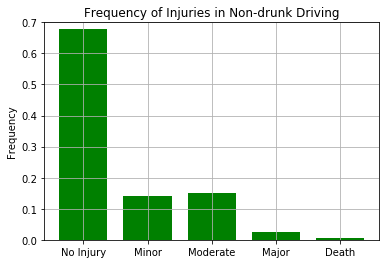

In [46]:
# Plots not drunk histogram
df_NotDrunk = df_isDrunk[df_isDrunk["DRINKING_DRIVER"] == 0]
graphNotDrunk = df_NotDrunk["MAX_SEVERITY_LEVEL"].hist(bins=range(0,6), align='left', rwidth=0.75, color='green', normed=1)
drunk_driving_x = ['No Injury','Minor', 'Moderate', 'Major', 'Death']

# Set labels
graphNotDrunk.set_ylim([0,0.7])
plt.xticks([0, 1, 2, 3, 4], drunk_driving_x)
plt.ylabel('Frequency')
plt.title('Frequency of Injuries in Non-drunk Driving')

# Show graph
plt.show()

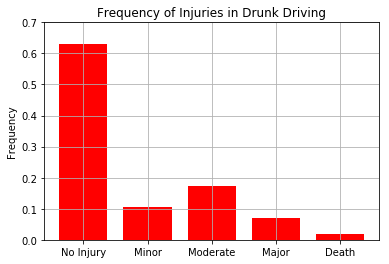

In [47]:
# Get if driver was drunk
df_Drunk = df_isDrunk[df_isDrunk['DRINKING_DRIVER'] == 1]

# Plot
graphDrunk = df_Drunk["MAX_SEVERITY_LEVEL"].hist(bins=range(0,6), align='left', rwidth=0.75, color='red', normed=1)

# Set labels
drunk_driving_x = ['No Injury','Minor', 'Moderate', 'Major', 'Death']
graphDrunk.set_ylim([0,0.7])
plt.xticks([0, 1, 2, 3, 4], drunk_driving_x)
plt.ylabel('Frequency')
plt.title('Frequency of Injuries in Drunk Driving')

# Show graph
plt.show()

<h3>Linear Classifier: Maximum Injury Severity Level ~ Drunk Driving</h3>

We run a linear classifier model on our dataset for drunk driving to see if we can find a sort of correlation.

In [48]:
# Runs linear classifier / t-test on data
outcome, predictors = patsy.dmatrices('MAX_SEVERITY_LEVEL ~ DRINKING_DRIVER', df_isDrunk)

# Use statsmodels to intialize the OLS model
mod = sm.OLS(outcome, predictors)

# Fit the model
res = mod.fit()

# Show results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     MAX_SEVERITY_LEVEL   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     36.01
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           2.03e-09
Time:                        19:59:20   Log-Likelihood:                -13215.
No. Observations:               10087   AIC:                         2.643e+04
Df Residuals:                   10085   BIC:                         2.645e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.5409      0.009     

Using alpha value 0.05, we find from the results of our linear regression analysis 0.393 is not < 0.05, so DRINKING_DRIVER does not predict the MAX_SEVERITY_LEVEL. The reason this might be that the graphs of the MAX_SEVERITY_LEVEL and DRINKING_DRIVER show that accident severity levels are heavily skewed towards 0 (no injury) and 1 (minor injury). Another possibility may be that the MAX_SEVERITY_LEVEL isn't the best indicator to be correlating due to the fact that the levels are somewhat arbitrary.

<h3>Amount of Accidents per Weather Condition</h3>

We look at how many accidents occur overall in the dataset for each weather condition.

In [49]:
# Create dataframe for weather with aggressive driving
df_weather_speed = df_trimmed[category_conditions + category_speed]

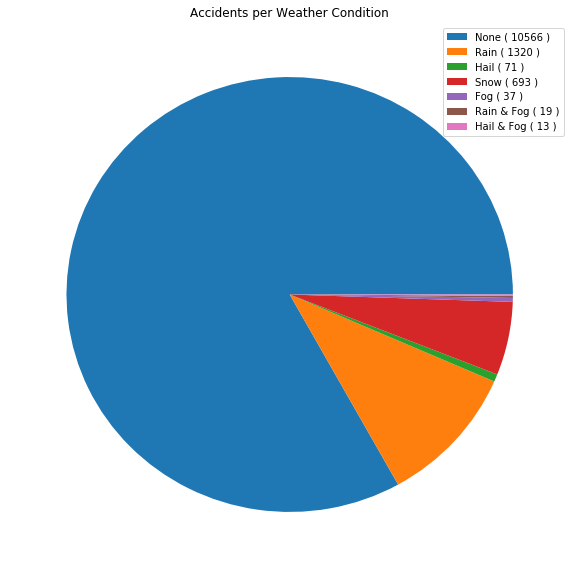

In [50]:
# Calculate weather counts
df_weather = df_weather_speed[df_weather_speed['WEATHER'] <= 7] #ignore conditions 8, 9
weather_counts = df_weather['WEATHER'].value_counts().sort_index()

# Pie graph of # of accidents per weather condition
lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
total_count = sum(weather_counts)

# Appends the values to lbls (since some pie slices too small to see)
for i in range(len(lbls)):
    #lbls[i] += " (" + str('%0.2f' % (weather_counts[i+1]/total_count * 100)) + "%)" #percentages
    lbls[i] += " ( " + str(weather_counts[i+1]) + " )" #counts
    
y = weather_counts
plt.figure(figsize=(8,8));
fig, ax = plt.subplots();
patches, texts = ax.pie(y);
plt.legend(patches, lbls);
plt.title("Accidents per Weather Condition")
fig.set_size_inches(10,10);
plt.show()

<h3>Weather Conditions with Injury Count</h3>

Below we run analysis on the data to see if we can find any patterns between weather conditions and injuries sustained in the average accident. First we run through the amount of injuries per weather condition.

In [51]:
# Create dataframe for weather and injuries
df_weather = df_trimmed[category_conditions + category_injury]

In [52]:
# Injury count with weather
df_weather_inj = df_weather[['WEATHER','INJURY_COUNT']]

# Calculate means for injury count
df_weather_mean_inj = []
df_weather_1_mean_inj =  df_weather[df_weather['WEATHER'] == 1]['INJURY_COUNT'].mean() # Good weather conditions 
df_weather_2_mean_inj =  df_weather[df_weather['WEATHER'] == 2]['INJURY_COUNT'].mean() # Rain
df_weather_3_mean_inj =  df_weather[df_weather['WEATHER'] == 3]['INJURY_COUNT'].mean() # Hail
df_weather_4_mean_inj =  df_weather[df_weather['WEATHER'] == 4]['INJURY_COUNT'].mean() # Snow
df_weather_5_mean_inj =  df_weather[df_weather['WEATHER'] == 5]['INJURY_COUNT'].mean() # Fog
df_weather_6_mean_inj =  df_weather[df_weather['WEATHER'] == 6]['INJURY_COUNT'].mean() # Rain and fog
df_weather_7_mean_inj =  df_weather[df_weather['WEATHER'] == 7]['INJURY_COUNT'].mean() # Hail and fog

# Append to list for injury
df_weather_mean_inj.append(df_weather_1_mean_inj)
df_weather_mean_inj.append(df_weather_2_mean_inj)
df_weather_mean_inj.append(df_weather_3_mean_inj)
df_weather_mean_inj.append(df_weather_4_mean_inj)
df_weather_mean_inj.append(df_weather_5_mean_inj)
df_weather_mean_inj.append(df_weather_6_mean_inj)
df_weather_mean_inj.append(df_weather_7_mean_inj)

# Show mean number of injuries per weather condition
df_weather_mean_inj

[0.592750331251183,
 0.5340909090909091,
 0.39436619718309857,
 0.3852813852813853,
 0.4594594594594595,
 0.3157894736842105,
 0.23076923076923078]

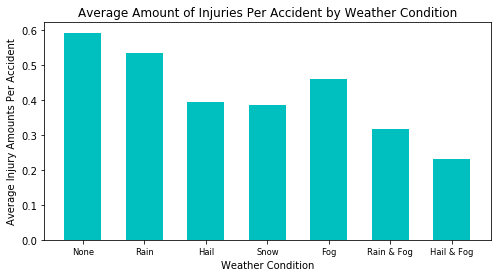

In [72]:
# Bar graph of means of injuries from driving per weather condition
x_lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
y = df_weather_mean_inj

plt.figure(figsize=(8,4))
weather_mean_inj_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')

plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title("Average Amount of Injuries Per Accident by Weather Condition")
plt.ylabel('Average Injury Amounts Per Accident')
plt.xlabel('Weather Condition')

plt.show()

We see that for weather conditions None and Rain, there seems to be a higher average injury count per accident than for the others conditions. This might mean there are less injury-causing accidents during certain adverse weather conditions. However, this might only be due to there being less cars on the road (or even less people in the cars themselves). It would be useful to analyze this data with the VEHICLE_COUNT if given the time.

<h3>Weather Conditions with Maximum Injury Severity Level</h3>

Next, after looking at the mean amount of injuries per weather condition, we will look at the maximum injury severity levels per weather condition.

In [54]:
# Max injury severity level with weather
df_weather_sev = df_weather[['WEATHER', 'MAX_SEVERITY_LEVEL']]
df_weather_sev = df_weather_sev[df_weather_sev['MAX_SEVERITY_LEVEL'] <= 4] # Severity level 8-9 is unknown and redundant

# Calculate means for max severity
df_weather_mean_sev = []
df_weather_1_mean_sev =  df_weather[df_weather['WEATHER'] == 1]['MAX_SEVERITY_LEVEL'].mean() # Good weather conditions 
df_weather_2_mean_sev =  df_weather[df_weather['WEATHER'] == 2]['MAX_SEVERITY_LEVEL'].mean() # Rain
df_weather_3_mean_sev =  df_weather[df_weather['WEATHER'] == 3]['MAX_SEVERITY_LEVEL'].mean() # Hail
df_weather_4_mean_sev =  df_weather[df_weather['WEATHER'] == 4]['MAX_SEVERITY_LEVEL'].mean() # Snow
df_weather_5_mean_sev =  df_weather[df_weather['WEATHER'] == 5]['MAX_SEVERITY_LEVEL'].mean() # Fog
df_weather_6_mean_sev =  df_weather[df_weather['WEATHER'] == 6]['MAX_SEVERITY_LEVEL'].mean() # Rain and fog
df_weather_7_mean_sev =  df_weather[df_weather['WEATHER'] == 7]['MAX_SEVERITY_LEVEL'].mean() # Hail and fog

# Append to list for max severity
df_weather_mean_sev.append(df_weather_1_mean_sev)
df_weather_mean_sev.append(df_weather_2_mean_sev)
df_weather_mean_sev.append(df_weather_3_mean_sev)
df_weather_mean_sev.append(df_weather_4_mean_sev)
df_weather_mean_sev.append(df_weather_5_mean_sev)
df_weather_mean_sev.append(df_weather_6_mean_sev)
df_weather_mean_sev.append(df_weather_7_mean_sev)

# Show mean maximum injury severity level per weather condition
df_weather_mean_sev

[2.287999242854439,
 2.099242424242424,
 1.591549295774648,
 1.8167388167388168,
 1.1891891891891893,
 1.4736842105263157,
 1.8461538461538463]

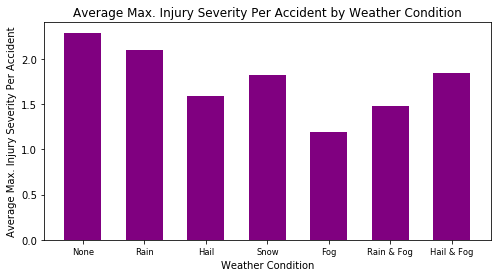

In [55]:
# Bar graph of means of max injury severity from driving per weather condition
x_lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
y = df_weather_mean_sev

plt.figure(figsize=(8,4))
weather_mean_inj_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='purple')

plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title("Average Max. Injury Severity Per Accident by Weather Condition")
plt.ylabel('Average Max. Injury Severity Per Accident')
plt.xlabel('Weather Condition')

plt.show()

In this graph, we find that once again None and Rain seem to have a higher average max injury severity per accident compared to the others. As in our earlier analysis of DRINKING_DRIVER and MAX_SEVERITY_LEVEL, the severity level may not be the best measurement of how severe accidents really are. Nor does it tell us that driving with None or Rain weather conditions is more dangerous. Seeing this correlation, however, we'd like to see if this means anything. As such, we will try to examine the driver behavior (aggresive driving, speeding) in these weather conditions in the next part.

<h3>Weather with Aggressive Driving</h3>
We will analyze the weather conditions with reports of aggressive driving in accidents next. 

In [80]:
# Weather with aggressive driving
df_weather_aggressive = df_weather_speed[['WEATHER','AGGRESSIVE_DRIVING']]

# Calculate aggressive ratios
df_weather_agg_ratio = []

# Aggressive driving for good weather conditions
df_weather_1_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 1]['AGGRESSIVE_DRIVING'] 
df_weather_1_agg_ratio = df_weather_1_agg.value_counts()[1] / (df_weather_1_agg.value_counts()[0] + df_weather_1_agg.value_counts()[1])

# Aggressive driving for rainy weather conditions
df_weather_2_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 2]['AGGRESSIVE_DRIVING'] 
df_weather_2_agg_ratio = df_weather_2_agg.value_counts()[1] / (df_weather_2_agg.value_counts()[0] + df_weather_2_agg.value_counts()[1])

# Aggressive driving for hailing weather conditions
df_weather_3_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 3]['AGGRESSIVE_DRIVING'] 
df_weather_3_agg_ratio = df_weather_3_agg.value_counts()[1] / (df_weather_3_agg.value_counts()[0] + df_weather_3_agg.value_counts()[1])

# Aggressive driving for snowy weather conditions
df_weather_4_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 4]['AGGRESSIVE_DRIVING'] 
df_weather_4_agg_ratio = df_weather_4_agg.value_counts()[1] / (df_weather_4_agg.value_counts()[0] + df_weather_4_agg.value_counts()[1])

# Aggressive driving for foggy weather conditions
df_weather_5_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 5]['AGGRESSIVE_DRIVING'] 
df_weather_5_agg_ratio = df_weather_5_agg.value_counts()[1] / (df_weather_5_agg.value_counts()[0] + df_weather_5_agg.value_counts()[1])

# Aggressive driving for rainy and foggy weather conditions
df_weather_6_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 6]['AGGRESSIVE_DRIVING'] 
df_weather_6_agg_ratio = df_weather_6_agg.value_counts()[1] / (df_weather_6_agg.value_counts()[0] + df_weather_6_agg.value_counts()[1])

# Aggressive driving for hailing and foggy weather conditions
df_weather_7_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 7]['AGGRESSIVE_DRIVING'] 
df_weather_7_agg_ratio = df_weather_7_agg.value_counts()[1] / (df_weather_7_agg.value_counts()[0] + df_weather_7_agg.value_counts()[1])

# Append to list
df_weather_agg_ratio.append(df_weather_1_agg_ratio)
df_weather_agg_ratio.append(df_weather_2_agg_ratio)
df_weather_agg_ratio.append(df_weather_3_agg_ratio)
df_weather_agg_ratio.append(df_weather_4_agg_ratio)
df_weather_agg_ratio.append(df_weather_5_agg_ratio)
df_weather_agg_ratio.append(df_weather_6_agg_ratio)
df_weather_agg_ratio.append(df_weather_7_agg_ratio)

# Print out ratios per weather condition
print (df_weather_agg_ratio)

[0.48485708877531708, 0.55227272727272725, 0.46478873239436619, 0.46897546897546899, 0.48648648648648651, 0.42105263157894735, 0.38461538461538464]


In [81]:
# Print out the mean and std_dev
mean_wea_agg = np.mean(df_weather_agg_ratio)
std_wea_agg = np.std(df_weather_agg_ratio)
print ("MEAN: " + str(mean_wea_agg))
print ("STD_DEV: " + str(std_wea_agg))

# Print the std_dev away for max and min
std_away1 = (df_weather_agg_ratio[1] - mean_wea_agg)/std_wea_agg #std_dev away for max
std_away2 = (df_weather_agg_ratio[6] - mean_wea_agg)/std_wea_agg #std_dev away for min
print (std_away1)
print (std_away2)

MEAN: 0.466149788586
STD_DEV: 0.0490948854981
1.75421406555
-1.66075148446


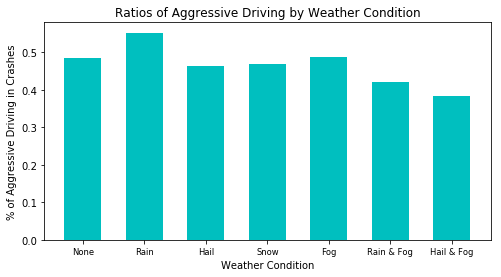

In [57]:
#Bar Graph of ratios of aggressive driving per weather condition
x_lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
y = df_weather_agg_ratio
plt.figure(figsize=(8,4))
weather_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title("Ratios of Aggressive Driving by Weather Condition")
plt.ylabel('% of Aggressive Driving in Crashes')
plt.xlabel('Weather Condition')
plt.show()

In this graph, we see that most of the ratios are fairly close (within one standard deviation from the mean). The exception being Hail & Fog (-1.6 std_dev) and Rain (1.7 std_Dev). Since there doesn't seem to be much of a difference, this doesn't tell us anything.

<h3>Weather with Speeding</h3>

We will analyze the ratios of speeding vs. not speeding in comparison to different weather conditions within crashes.

In [58]:
# Weather with speeding
df_weather_speeding = df_weather_speed[['WEATHER','SPEEDING']]
NUM_WEATHER_COND = 7; #ignore conditions (8: other, 9: unknown)

# Calculate speeding ratios (speeding vs total)
weather_spd_ratios = [0 for i in range(NUM_WEATHER_COND)]

for i in range(1,NUM_WEATHER_COND + 1):
    weather_spd = df_weather_speeding[df_weather_speeding['WEATHER'] == i]['SPEEDING']
    df_vc = weather_spd.value_counts() #counts the number of 0s for no speeding, 1s for speeding
    df_vc_idx = df_vc.index.tolist() #gets the values: [0, 1] in this case
    if len(df_vc) > 1:
        ratio = df_vc[1]/(df_vc[0] + df_vc[1]) #ratio of speeding vs total
    else:
        if df_vc_idx[0] == 0: #all accidents non speeding
            ratio = 0;
        else:
            ratio = 1; #all accidents speeding
    print("CONDITION: ", i)
    print(df_vc) #print the value counts
    weather_spd_ratios[i-1] = ratio

# Print out ratios per weather condition
weather_spd_ratios

CONDITION:  1
0    10151
1      415
Name: SPEEDING, dtype: int64
CONDITION:  2
0    1283
1      37
Name: SPEEDING, dtype: int64
CONDITION:  3
0    69
1     2
Name: SPEEDING, dtype: int64
CONDITION:  4
0    685
1      8
Name: SPEEDING, dtype: int64
CONDITION:  5
0    37
Name: SPEEDING, dtype: int64
CONDITION:  6
0    19
Name: SPEEDING, dtype: int64
CONDITION:  7
0    13
Name: SPEEDING, dtype: int64


[0.03927692598902139,
 0.02803030303030303,
 0.028169014084507043,
 0.011544011544011544,
 0,
 0,
 0]

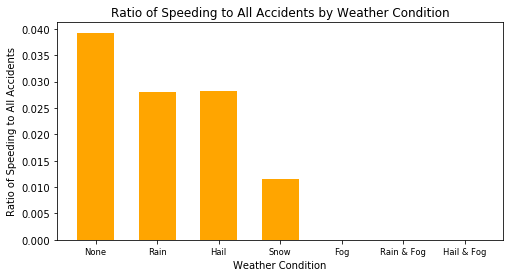

In [59]:
# Bar graph of ratios of speeding per weather condition
x_lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
y = weather_spd_ratios

plt.figure(figsize=(8,4))
weather_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='orange')

plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title("Ratio of Speeding to All Accidents by Weather Condition")
plt.ylabel('Ratio of Speeding to All Accidents')
plt.xlabel('Weather Condition')

plt.show()

When determining the ratios above, we found that they were 0 in some cases. Taking a look at the value counts, we discovered that for certain weather conditions such as 5, 6, 7 (Fog, Rain & Fog, Hail & Fog respectively) had a very small number of accidents. Even under 30 accidents in two cases. So their ratios being 0 may not be entirely accurate. Even hail had a relatively small number of 69 with respect to the general range of the ratios (all being under 4%).

The graph does seem to imply that speeding seems to be a less common occurrence in accidents during adverse weather conditions.

# ILLUMINATION

<h3>Accidents per Illumination Condition</h3>

We look at how many accidents per illumination condition make up a whole of the entire data.

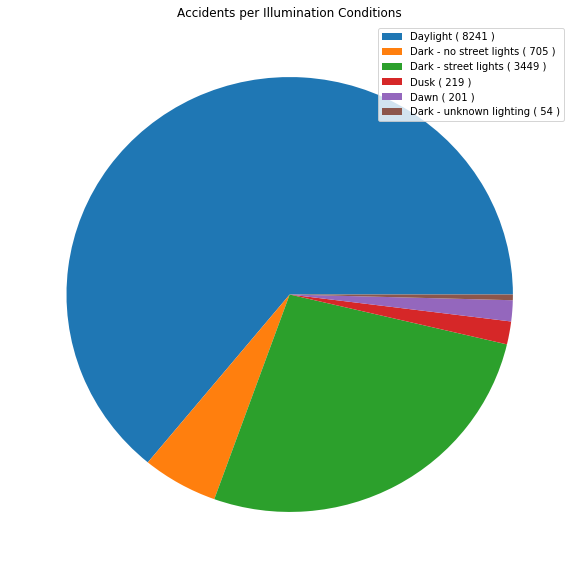

In [60]:
# Grab illumination counts
df_illum = df_weather_speed[df_weather_speed['ILLUMINATION'] <= 6] #exclude other, uknown illumination conditions
illum_counts = df_illum['ILLUMINATION'].value_counts().sort_index()

# Pie graph of amount of occurrences per weather condition
lbls = ['Daylight','Dark - no street lights', 'Dark - street lights', 'Dusk', 'Dawn', 'Dark - unknown lighting']
total_count = sum(illum_counts)

# Appends the percentage values to lbls (since some %s too small to see)
for i in range(len(lbls)):
    #lbls[i] += " (" + str('%0.2f' % (illum_counts[i+1]/total_count * 100)) + "%)" #percentages
    lbls[i] += " ( " + str(illum_counts[i+1]) + " )" #values

y = illum_counts
fig, ax = plt.subplots();
patches, texts = ax.pie(y);

plt.legend(patches, lbls);
plt.title("Accidents per Illumination Conditions")
fig.set_size_inches(10,10);

plt.show()

The pie chart shows that there are more accidents during the daylight than during other illumination conditions because there's just more traffic during the day. This graph is mainly to glean some information about the Dark with and without street light. The other categories Dusk and Dawn don't last too long and may be more difficult to analyze.

<h3>Illumination with Mean Injury Counts</h3>

Now that we are done with weather, we look at patterns in crashes in correspondance to illumination levels.

In [61]:
# Create dataframe for illumination conditions with injury counts
df_light = df_trimmed[category_conditions + category_injury]
df_light = df_light[['ILLUMINATION','INJURY_COUNT']]

# Calculate mean injury counts per lighting condition
df_light_mean = []
df_light_1_mean =  df_light[df_light['ILLUMINATION']==1]['INJURY_COUNT'].mean() # Daylight
df_light_2_mean =  df_light[df_light['ILLUMINATION']==2]['INJURY_COUNT'].mean() # Dark - no street light
df_light_3_mean =  df_light[df_light['ILLUMINATION']==3]['INJURY_COUNT'].mean() # Dark - street light
df_light_4_mean =  df_light[df_light['ILLUMINATION']==4]['INJURY_COUNT'].mean() # Dusk
df_light_5_mean =  df_light[df_light['ILLUMINATION']==5]['INJURY_COUNT'].mean() # Dawn
df_light_6_mean =  df_light[df_light['ILLUMINATION']==6]['INJURY_COUNT'].mean() # Dark - unknown roadway lighting

# Append means to list
df_light_mean.append(df_light_1_mean)
df_light_mean.append(df_light_2_mean)
df_light_mean.append(df_light_3_mean)
df_light_mean.append(df_light_4_mean)
df_light_mean.append(df_light_5_mean)
df_light_mean.append(df_light_6_mean)

# Print means per lighting condition
df_light_mean

[0.6070865186263803,
 0.4595744680851064,
 0.517541316323572,
 0.5799086757990868,
 0.48258706467661694,
 0.5555555555555556]

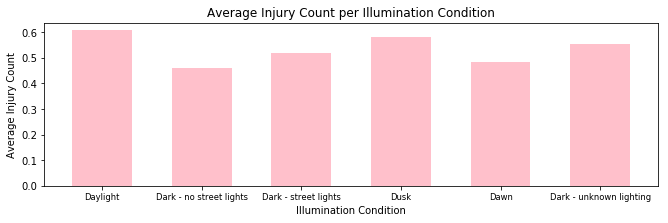

In [62]:
# Bar graph of ratios of mean injury counts per illumination condition
x_lbls = ['Daylight','Dark - no street lights', 'Dark - street lights', 'Dusk', 'Dawn', 'Dark - unknown lighting']
y = df_light_mean

plt.figure(figsize=(11,3))
ill_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='pink')

plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title('Average Injury Count per Illumination Condition')
plt.ylabel('Average Injury Count')
plt.xlabel('Illumination Condition')

plt.show()

Here, the average injury count is the highest in daylight. As with weather conditions, this may be just due to there being more drivers or more people in the cars during this time. For the difference in Dark with street lights and Dark without street lights, it might be that less cars travel on dark roads without light. This being so, this doesn't tell us much.

<h3>Illumination with Maximum Injury Severity Levels</h3>

We look at maximum injury severity levels for illumination conditions.

In [63]:
# Create dataframe for illumination conditions with max injury severity levels
df_light = df_trimmed[category_conditions + category_injury]
df_light = df_light[['ILLUMINATION','MAX_SEVERITY_LEVEL']]

# Calculate mean severity injury per lighting condition
df_light_mean = []
df_light_1_mean =  df_light[df_light['ILLUMINATION']==1]['MAX_SEVERITY_LEVEL'].mean() # Daylight
df_light_2_mean =  df_light[df_light['ILLUMINATION']==2]['MAX_SEVERITY_LEVEL'].mean() # Dark - no street light
df_light_3_mean =  df_light[df_light['ILLUMINATION']==3]['MAX_SEVERITY_LEVEL'].mean() # Dark - street light
df_light_4_mean =  df_light[df_light['ILLUMINATION']==4]['MAX_SEVERITY_LEVEL'].mean() # Dusk
df_light_5_mean =  df_light[df_light['ILLUMINATION']==5]['MAX_SEVERITY_LEVEL'].mean() # Dawn
df_light_6_mean =  df_light[df_light['ILLUMINATION']==6]['MAX_SEVERITY_LEVEL'].mean() # Dark - unknown roadway lighting

# Append means to list
df_light_mean.append(df_light_1_mean)
df_light_mean.append(df_light_2_mean)
df_light_mean.append(df_light_3_mean)
df_light_mean.append(df_light_4_mean)
df_light_mean.append(df_light_5_mean)
df_light_mean.append(df_light_6_mean)

# Print severity means per lighting condition
df_light_mean

[2.2095619463657323,
 1.8680851063829786,
 2.3447376051029285,
 2.182648401826484,
 1.8407960199004976,
 3.8333333333333335]

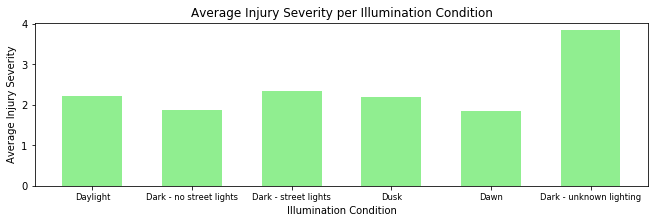

In [64]:
# Bar graph of ratios of mean severity injury per illumination condition
x_lbls = ['Daylight','Dark - no street lights', 'Dark - street lights', 'Dusk', 'Dawn', 'Dark - unknown lighting']
y = df_light_mean

plt.figure(figsize=(11,3))
ill_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='lightgreen')

plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title('Average Injury Severity per Illumination Condition')
plt.ylabel('Average Injury Severity')
plt.xlabel('Illumination Condition')

plt.show()

This graph shows that the average max injury severity levels for each illumination condition are fairly close except for Dark - unknown lighting. The reason for this might be that there are few instances (54 from the pie chart before) of this condition. Another explanation is that this illumination condition may be written for crashes with specific conditions unknown to us as the Crash Data Primer doesn't explain this. Ignoring this Dark - unknown lighting, the rest of the data still does not offer much.

<h3>Illumination with Aggressive Driving</h3>

We look at patterns in aggressive driving per illumination condition.

In [65]:
# Aggressive driving with illumination
df_ill_aggressive = df_weather_speed[['ILLUMINATION','AGGRESSIVE_DRIVING']]

# Calculate aggression with illumination
df_ill_agg_ratio = []

# Aggressive driving for daytime conditions
df_ill_1_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 1]['AGGRESSIVE_DRIVING'] 
df_ill_1_agg_ratio = df_ill_1_agg.value_counts()[1] / (df_ill_1_agg.value_counts()[0] + df_ill_1_agg.value_counts()[1])

# Aggressive driving for dark, no street light conditions
df_ill_2_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 2]['AGGRESSIVE_DRIVING'] 
df_ill_2_agg_ratio = df_ill_2_agg.value_counts()[1] / (df_ill_2_agg.value_counts()[0] + df_ill_2_agg.value_counts()[1])

# Aggressive driving for dark, with street light conditions
df_ill_3_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 3]['AGGRESSIVE_DRIVING'] 
df_ill_3_agg_ratio = df_ill_3_agg.value_counts()[1] / (df_ill_3_agg.value_counts()[0] + df_ill_3_agg.value_counts()[1])

# Aggressive driving for dusk conditions
df_ill_4_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 4]['AGGRESSIVE_DRIVING'] 
df_ill_4_agg_ratio = df_ill_4_agg.value_counts()[1] / (df_ill_4_agg.value_counts()[0] + df_ill_4_agg.value_counts()[1])

# Aggressive driving for dawn conditions
df_ill_5_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 5]['AGGRESSIVE_DRIVING'] 
df_ill_5_agg_ratio = df_ill_5_agg.value_counts()[1] / (df_ill_5_agg.value_counts()[0] + df_ill_5_agg.value_counts()[1])

# Aggressive driving for dark, unknown conditions
df_ill_6_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 6]['AGGRESSIVE_DRIVING'] 
df_ill_6_agg_ratio = df_ill_6_agg.value_counts()[1] / (df_ill_6_agg.value_counts()[0] + df_ill_6_agg.value_counts()[1])

# Append to list
df_ill_agg_ratio.append(df_ill_1_agg_ratio)
df_ill_agg_ratio.append(df_ill_2_agg_ratio)
df_ill_agg_ratio.append(df_ill_3_agg_ratio)
df_ill_agg_ratio.append(df_ill_4_agg_ratio)
df_ill_agg_ratio.append(df_ill_5_agg_ratio)
df_ill_agg_ratio.append(df_ill_6_agg_ratio)

# Print out ratios per illumination condition
df_ill_agg_ratio

[0.52323747118068198,
 0.39432624113475179,
 0.42853000869817337,
 0.53881278538812782,
 0.40298507462686567,
 0.37037037037037035]

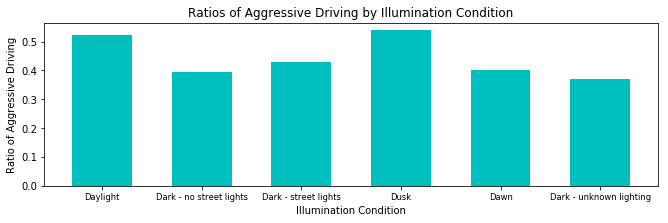

In [66]:
# Bar graph of ratios of aggressive driving per illumination condition
x_lbls = ['Daylight','Dark - no street lights', 'Dark - street lights', 'Dusk', 'Dawn', 'Dark - unknown lighting']
y = df_ill_agg_ratio

plt.figure(figsize=(11,3))
ill_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')

plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title('Ratios of Aggressive Driving by Illumination Condition')
plt.ylabel('Ratio of Aggressive Driving')
plt.xlabel('Illumination Condition')

plt.show()

Here, it appears that during Daylight and Dusk there is a higher ratio of aggresive driving than in the other illumination conditions. The reason for this could be that there are more drivers on the road (maybe during rush hour) and as a consequence have people become more aggressive towards others (like slow drivers). 

<h3>Illumination with Speeding</h3>

We look at patterns of speeding per illumination condition.

In [86]:
# Weather with speeding
df_illum_speeding = df_weather_speed[['ILLUMINATION','SPEEDING']]
NUM_ILLUM_COND = 6; #ignore conditions (8: other, 9: unknown)

# Calculate speeding ratios (speeding vs total)
illum_spd_ratios = [0 for i in range(NUM_ILLUM_COND)]

for i in range(1,NUM_ILLUM_COND + 1):
    illum_spd = df_illum_speeding[df_illum_speeding['ILLUMINATION'] == i]['SPEEDING']
    df_vc = illum_spd.value_counts() #counts the number of 0s for no speeding, 1s for speeding
    df_vc_idx = df_vc.index.tolist() #gets the values: [0, 1] in this case
    if len(df_vc) > 1:
        ratio = df_vc[1]/(df_vc[0] + df_vc[1]) #ratio of speeding vs total
    else:
        if df_vc_idx[0] == 0: #all accidents non speeding
            ratio = 0;
        else:
            ratio = 1; #all accidents speeding
    #print("CONDITION: ", i)
    #print(df_vc) #print the value counts
    illum_spd_ratios[i-1] = ratio

# Print out ratios per weather condition
illum_spd_ratios

[0.024390243902439025,
 0.04397163120567376,
 0.062336909249057701,
 0.027397260273972601,
 0.03482587064676617,
 0.037037037037037035]

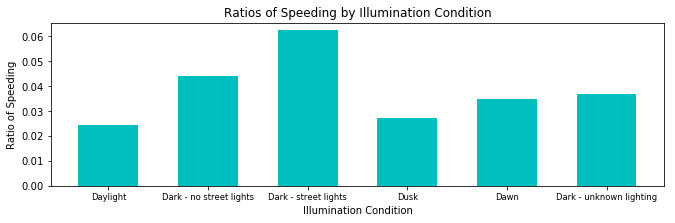

In [87]:
# Bar graph of ratios of speeding per illumination condition
x_lbls = ['Daylight','Dark - no street lights', 'Dark - street lights', 'Dusk', 'Dawn', 'Dark - unknown lighting']
y = illum_spd_ratios

plt.figure(figsize=(11,3))
ill_spd_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')

plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title('Ratios of Speeding by Illumination Condition')
plt.ylabel('Ratio of Speeding')
plt.xlabel('Illumination Condition')

plt.show()

This graph shows that the ratio of speeding is much higher during the Dark regardless of street lighting. This makes sense as during the dark there are less cars (and probably less chance of police), so drivers think they can get away of speeding. Even though the previous graph showed that aggressive driving during the dark was a bit lower than in during the day, that in no way concluded that people drive more safely; people, instead, speed at night.

# ACCIDENTS PER MONTH

We look at which months compromise of how many accidents.

In [67]:
# Create dataframe for weather with month
df_weather_time = df_trimmed[category_conditions + category_time]

In [68]:
df_month = df_weather_time[['CRASH_MONTH']]
NUM_MONTH = 12;

# Calculate speeding ratios (speeding vs total)
month_counts = df_month['CRASH_MONTH'].value_counts().sort_index()

# Print out ratios per weather condition
month_counts

1     1305
2     1006
3      904
4     1035
5     1038
6     1044
7      973
8     1091
9     1017
10    1149
11    1072
12    1266
Name: CRASH_MONTH, dtype: int64

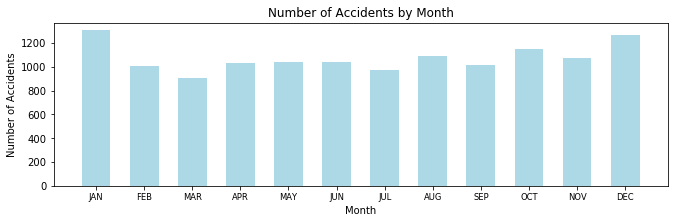

In [69]:
# Graph accidents per month
x_lbls = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
y = month_counts

plt.figure(figsize=(11,3))
month_count_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='lightblue')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')

plt.title('Number of Accidents by Month')
plt.ylabel('Number of Accidents')
plt.xlabel('Month')

plt.show()

This graph shows that the number of accidents seem to have a slight increase in January and December. We speculate that this could be weather, but it could just be increased traffic during the time of year.

# Conclusion / Discussion:

<h3>Conclusion</h3>


<h3>Discussion</h3>
Given more time, there are many more different factors to explore for driver behavior in different weather and different illumination conditions. It would be interesting to explore the affect of weather and/or illumination conditions on the severity level of accidents within a region (using heatmaps). Additionally, it would be insightful to combine multiple factors or try to narrow down certain categories to better analyze the data. For example, to better understand the mean injury counts in different weather or illumination conditions also get the vehicle counts to see how many vehicles are involved.

# Contributions

<b>Andy Thai</b>

Helped write initial proposal for project. 
Helped clean and trim data.
Wrote data analysis code and some graphs for parts of weather conditions, drunk driving, and illumination. 
Cleaned up overall notebook.

<b>Johnson Pang</b>

Helped discuss initial proposal.
Wrote data analysis code and graphs for speeding, weather conditions and illumination.
Wrote data analysis/results for sections.

<b>Ronald Baldonado</b>

<b>Charles Wang</b>